In [1]:
from setup_libs import *

# XGBOOST

Первый алгоритм, который находится вне sklearn, так как его создавала сторонняя команда с большим числом прикольных фич.

[Установка](https://xgboost.readthedocs.io/en/latest/build.html)

# [Xgboost, Регуляризация](https://xgboost.readthedocs.io/en/latest/tutorials/model.html?highlight=boosting%20trees)

Проблема многих алгоритмов построения деревьев в том, что в них не уделяется должного внимания **регуляризации**. 
В классическом градиентном бустинге применяется такие меры:
- ограничение на структуру дерева: максимальная глубина (max_depth), минимальное число объектов в листе (min_samples_leaf)
- контролирование темпа обучения (learning_rate)
- увеличение "непохожести" деревьев за счет рандомизации, как в случайном лесе

[Xgboost](https://github.com/dmlc/xgboost) использует еще больше параметров для регуляризации базовых деревьев.

Бустинг строит композицию из $K$ базовых алгоритмов $b_k$:

$$ \hat{y}_i = \hat{y}_i^{K} = \sum_{k=1}^{K} b_k(x_i) = \hat{y}_i^{\left(K - 1\right)} + b_K(x_i), $$

С учетом регуляризации XGBoost минимизирует следующий функционал:

$$ Obj = \sum_{i=1}^N \mathcal{L}(y_i, \hat{y}_i ) + \sum_{k=1}^{K} \Omega(b_k),$$

где
 - $N$ — размер обучающей выборки;
 - $x_i, y_i, \hat{y}_i$ — i-ый объект, правильный ответ и предсказание модели для него;
 - $\hat{y}_i^{t}$ — предсказание композиции из $t$ уже обученных базовых алгоритмов для i-го объекта;
 - $\Omega$ — регуляризатор;
 - $\mathcal{L}(y_i, \hat{y}_i)$ — функция потерь.


Функционал, оптимизируемый на $t$-ой итерации:

$$ Obj^{(t)} = \sum_{i=1}^N \mathcal{L}\left(y_i, \hat{y}_i^{(t-1)} + b_t(x_i)\right) + \Omega(b_t).$$

В случае бустинга над **решающими деревьями** регуляризатор имеет следующий вид:

$$ \Omega(b_t) = \gamma T + \frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2 + \alpha\sum_{j=1}^{T}|w_j|,$$

где 
 - $T$ — **количество листьев в дереве**;
 - $w_j$ — **веса в листьях дерева** (вероятность попадания в лист по тренировочной выборке);
 - $\lambda, \alpha, \gamma$ — **гиперпараметры**

# Пример использования Xgboost 
**Классификации на данных Iris.**

**Пример восстановления регрессии с Xgboost на данных boston.**

In [2]:
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=5, shuffle=True, random_state=17)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBRegressor().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(MSE(actuals, predictions))

9.047410732647124
8.691280669876079
15.025941773762074
7.385308075054494
7.329729069724167


**Простой пример подбора параметров с GridSearchCV.**

In [3]:
X = boston['data']
y = boston['target']

xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb_model,{'max_depth': [2,4,6]}, verbose=1)
xgb_grid.fit(X,y)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6839859042772509
{'max_depth': 2}


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.7s finished


## Early stopping
**Ранняя остановка используется для того, чтобы прекратить обучение модели (градиентный спуск), если ошибка за несколько итераций не уменьшилась.**

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()

X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, 
        early_stopping_rounds=10, #Ранняя остановка 
        eval_metric="merror",
        eval_set=[(X_test, y_test)])

[0]	validation_0-merror:0.14000
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.10667
[2]	validation_0-merror:0.08222
[3]	validation_0-merror:0.08000
[4]	validation_0-merror:0.06667
[5]	validation_0-merror:0.06444
[6]	validation_0-merror:0.07111
[7]	validation_0-merror:0.07111
[8]	validation_0-merror:0.06889
[9]	validation_0-merror:0.06667
[10]	validation_0-merror:0.06444
[11]	validation_0-merror:0.06667
[12]	validation_0-merror:0.06889
[13]	validation_0-merror:0.06000
[14]	validation_0-merror:0.05778
[15]	validation_0-merror:0.06222
[16]	validation_0-merror:0.06000
[17]	validation_0-merror:0.05778
[18]	validation_0-merror:0.05556
[19]	validation_0-merror:0.05333
[20]	validation_0-merror:0.05556
[21]	validation_0-merror:0.05556
[22]	validation_0-merror:0.04889
[23]	validation_0-merror:0.04889
[24]	validation_0-merror:0.05111
[25]	validation_0-merror:0.05333
[26]	validation_0-merror:0.05111
[27]	validation_0-merror:0.04889
[28]	validation_0-m

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

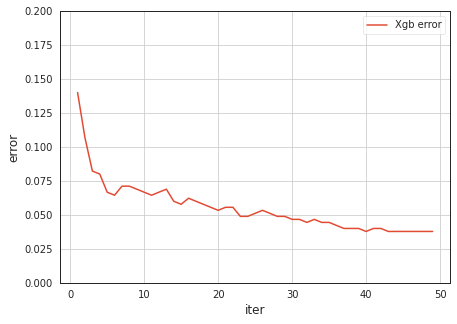

In [5]:
errors_by_iter = clf.evals_result()['validation_0']['merror']
plt.plot(range(1, len(errors_by_iter) + 1), errors_by_iter, label='Xgb error')
plt.xlabel('iter')
plt.ylabel('error')
plt.ylim(0, 0.2)
plt.legend()
plt.grid()

# [Параметры XGBoost](https://xgboost.readthedocs.io/en/latest/parameter.html)

Более развернутую информацию можно найти в файле parametrs.txt и на [сайте](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

Выделяют три группы параметров:
- Общие параметры, отвечающие за базовый алгоритм для бустинга и распараллеливание.
- Параметры выбранного базового алгоритма.
- Параметры обучения, отвечающие за функцию потерь и метрику качества на валидации.

**1. Общие параметры:**
- booster [default=gbtree] - тип базового алгоритма для бустинга: **дерево решений** gbtree или **линейная модель** gblinear. 
- silent [default=0] - выдавать (silent=0) или нет (silent=1) сообщения по ходу работы алгоритма.
- nthread [default to maximum number of threads available if not set] - число нитей доступных для параллельной работы xgboost.

**2. Параметры базового алгоритма:**

**2.1. Дерево решений:**
Параметры как в стандартном дереве решений: `eta`, `gamma`, `max_depth`, `min_child_weight`, `max_delta_step`, `subsample` и.т.д.

**2.2. Линейная модель:**
- lambda [default=0] - коэффициент перед $L_2$-регуляризатором вектора весов в функции потерь.
- alpha [default=0] - коэффициент перед $L_1$-регуляризатором вектора весов в функции потерь.
- lambda_bias [default=0] - коэффициент перед $L_2$-регуляризатором смещения (свободного члена) в функции потерь.

**3. Параметры задачи обучения:**
- **objective** [default=reg:linear] - используемая при обучении функция потерь:
    * `reg:linear`, `reg:logistic`, `binary:logistic`, `binary:logitraw`, `count:poisson`, `multi:softmax`, `multi:softprob`, `rank:pairwise`
- **base_score** [default=0.5] - инициализация значения модели для всех примеров, глобальное смещение.
- **eval_metric** [default according to objective] - метрика качества на валидационной выборке (по умолчанию соответствует функции потерь: rmse - для регрессии, error - для классификации, mean average precision - для ранжирования). Выбрать можно одну из следующих метрик:
    - `rmse`, `logloss`, `error`, `merror`, `mlogloss`, `auc`, `ndcg`, `map` и.т.д.
- **seed** [default=0] - для воспроизводимости "случайности".


## Сравнение алгоритмов по времени работы

Посмотрим на время обучения классификаторов XGBooster и GradientBoostingClassifier. Для этого будем генерировать выборку из 1000 объектов и 50 признаков с помощью sklearn.datasets.make_classification и замерять время обучения.

In [ ]:
from tqdm.notebook import tqdm
import time

xgb_params1 = {'booster': 'gbtree', 
               'n_estimators': 100, 
               'max_depth': 3, 
               'eta': 0.1, 
               'silent': 1, 
               'objective': 'binary:logistic', 
               'nthread': 1}

xgb_params2 = {'booster': 'gbtree', 
               'n_estimators': 100, 
               'max_depth': 3, 
               'eta': 0.1, 
               'silent': 1, 
               'objective': 'binary:logistic', 
               'nthread': 4}

sklearn_params = {'n_estimators': 100, 'max_depth': 3}

xgb_time1 = list()
xgb_time2 = list()
sklearn_time = list()

n_runs = 50

for i in tqdm(range(n_runs)):
    # Generating dataset
    X, y = make_classification(n_samples=1000, n_features=50, n_informative=20)
    # Training XGBooster (nthread=1)
    t = time.time()
    bst = xgb.XGBClassifier(**xgb_params1).fit(X, y)
    elapsed = time.time() - t
    xgb_time1.append(elapsed)
    # Training XGBooster (nthread=4)
    t = time.time()
    bst = xgb.XGBClassifier(**xgb_params2).fit(X, y)
    elapsed = time.time() - t
    xgb_time2.append(elapsed)
    # Training GradientBoostingClassifier
    t = time.time()
    clf = GradientBoostingClassifier(**sklearn_params).fit(X, y)
    elapsed = time.time() - t
    sklearn_time.append(elapsed)

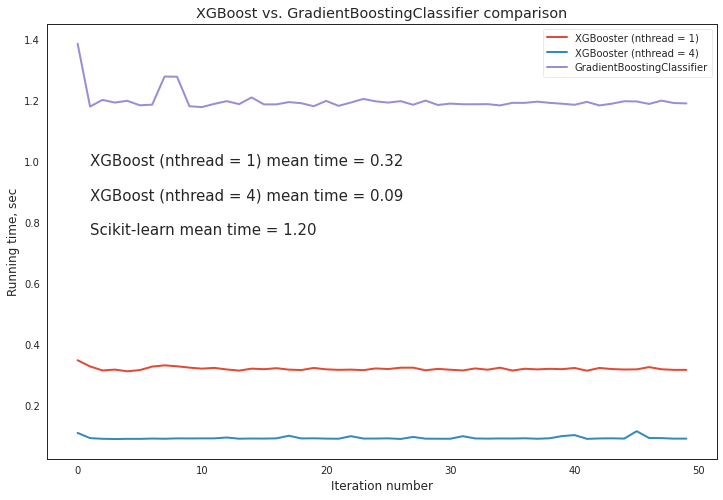

In [11]:
%matplotlib  inline
import matplotlib.pyplot as plt

xgb_mean1 = sum(xgb_time1) / n_runs
xgb_mean2 = sum(xgb_time2) / n_runs
sklearn_mean = sum(sklearn_time) / n_runs

plt.figure(figsize=(12, 8))
plt.plot(xgb_time1, label='XGBooster (nthread = 1)', lw=2)
plt.plot(xgb_time2, label='XGBooster (nthread = 4)', lw=2)
plt.plot(sklearn_time, label='GradientBoostingClassifier', lw=2)
plt.legend(loc='best')
plt.text(1, (xgb_mean1 + sklearn_mean) / 2, 
         'XGBoost (nthread = 1) mean time = %.2f' % xgb_mean1 +
         '\n\nXGBoost (nthread = 4) mean time = %.2f' % xgb_mean2 +
         '\n\nScikit-learn mean time = %.2f' % sklearn_mean,
            fontsize = 15)
plt.xlabel('Iteration number')
plt.ylabel('Running time, sec')
plt.title('XGBoost vs. GradientBoostingClassifier comparison')
plt.show()

## Выводы

Основные преимущества XGBoost по сравнению с sklearn.ensembles.GradientBoostingClassifier:
- Помимо деревьев возможно использование линейных моделей в качестве базовых классификаторов.
- Скорость работы.
- Возможность распараллеливания.
- Значительно больший выбор стандартных функций потерь, а также возможность задавать свою функцию потерь.
- Наличие регуляризаторов в итоговой функции потерь и возможность задавать их коэффициенты, что даёт еще один метод борьбы с переобучением, помимо использования случайности (subsample, colsample_bytree) и основных параметров дерева решений.
- Встроенная обработка missing values.

# Feature Importance

### Важность признаков

**F score при оценке важности признаков в Xgboost (не путать с F1 score как метрики качества классификации) вычисляется на основе того, как часто разбиение делалось по данному признаку.**

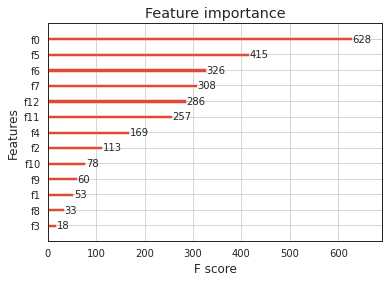

In [21]:
boston = load_boston()
y = boston['target']
X = boston['data']
X_train, X_test, y_train, y_test = train_test_split(X, y)
xgb_model = xgb.XGBRegressor().fit(X_train,y_train)
xgb.plot_importance(xgb_model);

Или так

In [23]:
xgb_model.feature_importances_

array([0.02892063, 0.00223669, 0.01215404, 0.0018891 , 0.03679178,
       0.2790266 , 0.00800839, 0.04944727, 0.01147965, 0.04604128,
       0.0352719 , 0.00868248, 0.48005015], dtype=float32)

# Python Interface

XGBoost разрабатывался независимо от sklearn библиотеки, поэтому изначально в нем присутствовал более низкоуровневый интерфейс. Сейчас принято использовать интерфейс sklearn, так как он интегрируется в другие полезные функции, например GridSearch. Однако полезно знать и использовать начальный интерфейс.



In [39]:
df = pd.read_csv('data/telecom_churn.csv')

In [40]:
state_enc = LabelEncoder()
df['State'] = state_enc.fit_transform(df['State'])
df['International plan'] = (df['International plan'] == 'Yes').astype('int')
df['Voice mail plan'] = (df['Voice mail plan'] == 'Yes').astype('int')
df['Churn'] = (df['Churn']).astype('int')

Первая особенность - тренировочные и обучающие выборки оборачиваются в специальный класс [DMatrix](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=dmatrix#xgboost.DMatrix). О специфике формата и то, как в нем представляются данные, можно прочитать [здесь](https://xgboost.readthedocs.io/en/latest/tutorials/input_format.html)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'],
                                                    test_size=0.3, stratify=df['Churn'], random_state=17)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

**Посмотрим на статистику полученных объектов:**

In [42]:
print("Train dataset contains {0} rows and {1} columns".format(dtrain.num_row(), dtrain.num_col()))
print("Test dataset contains {0} rows and {1} columns".format(dtest.num_row(), dtest.num_col()))

Train dataset contains 2333 rows and 19 columns
Test dataset contains 1000 rows and 19 columns


In [43]:
print("Train mean target: ")
print(np.mean(dtrain.get_label()))

print("\nTest mean target: ")
print(np.mean(dtest.get_label()))

Train mean target: 
0.14487784

Test mean target: 
0.145


### Инициализация параметров

Второе существенное отличие, у нас нет различных алгоритмов для разных типов задач (`XGBClassifier`, `XGBRegressor` и.т.д.), у нас есть один метод `train` и в нем мы уже корректно определяем задачу `objective` и остальные параметры

- бинарная классификация (`'objective':'binary:logistic'`)
- ограничим глубину деревьев (`'max_depth':3`)
- не хотим лишнего вывода (`'silent':1`)
- проведем 50 итераций бустинга
- шаг градиентного спуска довольно большой (`'eta':1`) - алгоритм будет обучаться быстро и "агрессивно" (лучше результаты будут, если уменьшить eta и увеличить число итераций)


In [44]:
params = {
    'objective':'binary:logistic',
    'max_depth': 3,
    'silent': 1,
    'eta': 1
}

num_rounds = 50

### Обучение классификатора
Тут мы просто передаем словарь параметров, данные и число итераций.

In [45]:
xgb_model = xgb.train(params, dtrain, num_rounds)

**С помощью `watchlist` отслеживать качество алгоритма на тестовой выборке для каждой итерации.**

In [46]:
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.11600	train-error:0.09087
[1]	test-error:0.10200	train-error:0.06858
[2]	test-error:0.07100	train-error:0.04029
[3]	test-error:0.06400	train-error:0.03472
[4]	test-error:0.07100	train-error:0.03601
[5]	test-error:0.07000	train-error:0.03386
[6]	test-error:0.06900	train-error:0.03215
[7]	test-error:0.07300	train-error:0.03043
[8]	test-error:0.07000	train-error:0.02872
[9]	test-error:0.07400	train-error:0.02872
[10]	test-error:0.07000	train-error:0.02829
[11]	test-error:0.07000	train-error:0.02872
[12]	test-error:0.06300	train-error:0.02658
[13]	test-error:0.06700	train-error:0.02443
[14]	test-error:0.06900	train-error:0.02186
[15]	test-error:0.06900	train-error:0.02143
[16]	test-error:0.06800	train-error:0.02186
[17]	test-error:0.06300	train-error:0.01929
[18]	test-error:0.07000	train-error:0.02100
[19]	test-error:0.06700	train-error:0.01886
[20]	test-error:0.06900	train-error:0.01929
[21]	test-error:0.06800	train-error:0.01800
[22]	test-error:0.06500	train-error:0.0167

### Прогнозы для тестовой выборки

In [47]:
preds_prob = xgb_model.predict(dtest)

**Посчитаем долю правильных ответов алгоритма на тестовой выборке.**

In [49]:
from sklearn.metrics import f1_score

predicted_labels = preds_prob > 0.5
print("Accuracy and F1 on the test set are: {} and {}".format(
    round(accuracy_score(y_test, predicted_labels), 3),
    round(f1_score(y_test, predicted_labels), 3)))

Accuracy and F1 on the test set are: 0.935 and 0.749


## Полезные ссылки
- <a href="https://en.wikipedia.org/wiki/Boosting_(machine_learning)">Boosting Wikipedia</a>
- [Gradient boosting. Wikipedia](https://en.wikipedia.org/wiki/Gradient_boosting)
- [Лекция Слайды Воронцова 2018г](http://www.machinelearning.ru/wiki/images/c/cd/Voron-ML-Compositions-slides.pdf) К.В. Воронцова по композиционным методам классификации
- <a href="https://github.com/dmlc/xgboost">Github Xgboost</a>
- <a href="https://github.com/ChenglongChen/Kaggle_CrowdFlower">Обзор</a> решения победителя соревнования Kaggle "CrowdFlower" по предсказанию релевантности выдачи поисковика товаров. Решение на основе Xgboost

- [XGBoost doc](https://xgboost.readthedocs.org/en/latest/parameter.html)
- [GradientBoostingClassifier. Sklearn doc](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [Сравнение](https://github.com/szilard/benchm-ml) различных библиотек для машинного обучения, в том числе sklearn и xgboost 